In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from dataloader import INSPIRE
from model import *

from tqdm import tqdm
import numpy as np
import json

from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, recall_score, \
                            precision_score, f1_score, roc_auc_score, \
                            average_precision_score

from sklearn.metrics import confusion_matrix

from utils import calculate_integrated_gradients

import pandas as pd

In [221]:
# -------  环境变量 -----------
y_name = "hr"
y_index = 7
stage = "in"
device = torch.device("cuda:0")

fn_1 = pd.read_csv("/home/luojiawei/pengxiran_project/fn1.csv",header=0).iloc[:,1]
fn_2 = pd.read_csv("/home/luojiawei/pengxiran_project/fn2.csv",header=0).iloc[:,1]
fn_3 = pd.read_csv("/home/luojiawei/pengxiran_project/fn3.csv",header=0).iloc[:,1]
fn_4 = pd.read_csv("/home/luojiawei/pengxiran_project/fn4.csv",header=0).iloc[:,1]
fn_5 = pd.read_csv("/home/luojiawei/pengxiran_project/fn5.csv",header=0).iloc[:,1]

In [222]:
dataset_te = INSPIRE("/home/luojiawei/pengxiran_project_data/all_op_id1/",
                    "/home/luojiawei/pengxiran_project_data/ds_id.csv",
                    id_col="op_id",
                    mod_col="set",
                    mod = [2],
                    cls_col = None,
                    cls = None,
                    stat_path="/home/luojiawei/pengxiran_project/deep_learning/stat_info"
                    )

all_id 的数量: 20267


/home/luojiawei/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3473: DtypeWarning: Columns (43) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [223]:
# lab_pre/post 36 + 36, vit_pre 76 + 75, vit_in 75 + 75, vit_post 75 + 75, x_s 37, oper 5
input_size_list = [36 + 36 + 48, 76 + 75, 75 + 75]
hidden_size_list = [256, 256, 256]
output_size_list = [3]
type_list = ["cat"]
model_list = ["mlp","biattlstm","biattlstm"]

In [224]:
model = PredModel(input_size_list, hidden_size_list, model_list, output_size_list, type_list)
model.load_state_dict(torch.load("/home/luojiawei/pengxiran_project/deep_learning/saved_param/model_hr_in.pth"))
model = model.to(device)

In [263]:
datas = dataset_te.get_1data(7803, normalize=True)

lab_pre, mask_lab_pre, lab_post, mask_lab_post, \
    vit_pre, mask_pre, vit_in, mask_in, vit_post, mask_post, \
    t_list, x_s, oper_info, \
    y_mat, y_mask, y_static, y_mask1 = datas

lab_pre = lab_pre.to(device)
mask_lab_pre = mask_lab_pre.to(device)
lab_post = lab_post.to(device)
mask_lab_post = mask_lab_post.to(device)

vit_pre = vit_pre.unsqueeze(0).to(device)
mask_pre = mask_pre.unsqueeze(0).to(device)
vit_in = vit_in.unsqueeze(0).to(device)
mask_in = mask_in.unsqueeze(0).to(device)  
vit_post = vit_post.unsqueeze(0).to(device)
mask_post = mask_post.unsqueeze(0).to(device)            

x_s = x_s.to(device)
oper_info = oper_info.to(device)

x_1 = torch.cat([lab_pre, mask_lab_pre, x_s], dim=-1)
x_2 = torch.cat([vit_pre, mask_pre], dim=-1)
x_3 = torch.cat([vit_in, mask_in], dim=-1)
# x_4 = torch.cat([vit_post, mask_post], dim=-1)
# x_5 = torch.cat([lab_post, mask_lab_post, oper_info], dim=-1)

y_mat = y_mat.to(device)
y_mask = y_mask.to(device)

In [264]:
y_true, y_pred = [], []
for j in range(1, y_mat.shape[0]):
    
    # if random.random() < 0.5:
    #     continue
    if y_mask[j, 0] == 0:
        continue
    x_3_ = x_3[:,:j]
    yhat_list = model([x_1,x_2,x_3_])
    y_pred.append(yhat_list[0])
    y_true.append(y_mat[j:(j+1),y_index:(y_index+1)])

y_pred = torch.cat(y_pred, dim=0)
y_true = torch.cat(y_true, dim=0).to(torch.int64)
y_pred_max_indices = np.argmax(y_pred.cpu().data.numpy(), axis=1)
y_pred_max_indices = np.expand_dims(y_pred_max_indices, axis=1)

In [266]:
# np.round(vit_in.cpu().data.numpy(),2)[:,:,40:50]

In [294]:
# np.round(np.concatenate([y_pred.cpu().data.numpy(), y_pred_max_indices, y_true.cpu().data.numpy()], axis=1),2)

In [295]:
# x_3.shape

In [289]:
j = 12
x_3_ = x_3[:,:j]
yhat_list = model([x_1,x_2,x_3_])
print(y_mat[j:(j+1),y_index:(y_index+1)])
print(yhat_list[0][0].argmax())
print(np.round(yhat_list[0].cpu().data.numpy(),3))

tensor([[0.]], device='cuda:0')
tensor(0, device='cuda:0')
[[0.63 0.37 0.  ]]


In [291]:
# yhat_list[0][0].cpu().data.argmax().item()
grads = calculate_integrated_gradients([x_1,x_2,x_3_], model, yhat_list[0][0].cpu().data.argmax().item(), steps=50, device=device)
grads[1] = grads[1].sum((0,1))
grads[2] = grads[2].sum((0,1))
fea_imp = np.concatenate([grads[0][0], grads[1],grads[2]], axis=0)
fn = fn_1.tolist() + fn_2.tolist() + fn_3.tolist()

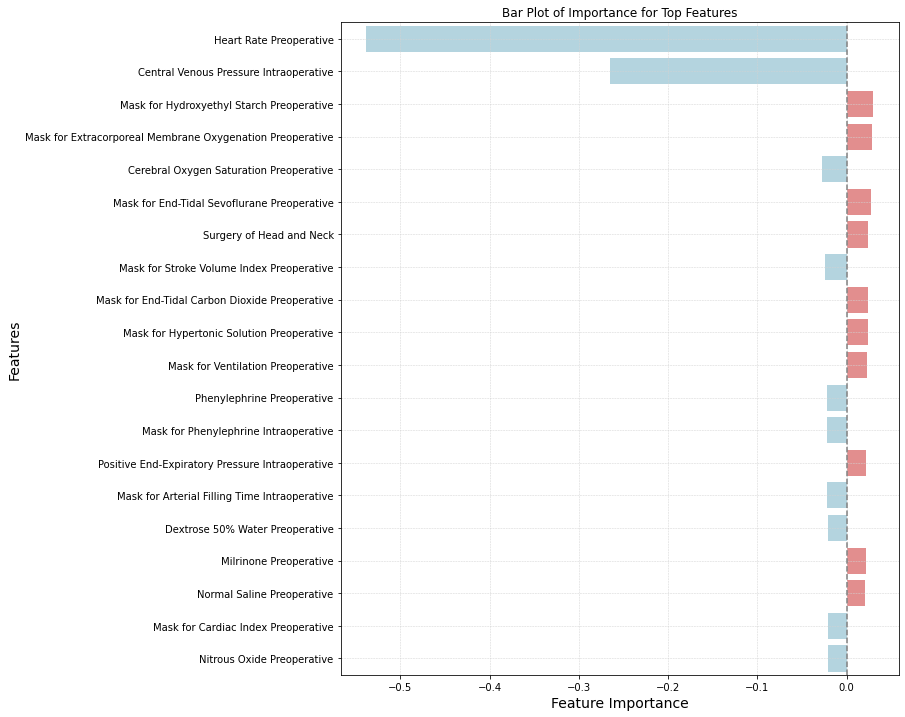

In [293]:
import matplotlib.pyplot as plt
import seaborn as sns

# 计算特征重要性的绝对值的平均
abs_imp = np.abs(fea_imp)

# 选择前 n 个最重要的特征
n = 20
top_indices = np.argsort(-abs_imp)[:n]

# 根据特征重要性的正负定义颜色
colors = ['lightcoral' if x > 0 else 'lightblue' for x in fea_imp[top_indices]]

plt.figure(figsize=(10, 12))
bar_plot = sns.barplot(x=fea_imp[top_indices], y=[fn[i] for i in top_indices], palette=colors)
plt.title('Bar Plot of Importance for Top Features')
plt.xlabel('Feature Importance',fontsize=14)
plt.ylabel('Features',fontsize=14)
plt.axvline(x=0, color='grey', linestyle='--') 
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey') 
plt.show()

In [297]:
fn = fn_1.tolist() + fn_2.tolist() + fn_3.tolist()

In [298]:
fea_imp_list = []
for j in range(1, x_3.shape[1]):
    x_3_ = x_3[:,:j]
    yhat_list = model([x_1,x_2,x_3_])
    grads = calculate_integrated_gradients([x_1,x_2,x_3_], model, yhat_list[0][0].cpu().data.argmax().item(), steps=50, device=device)
    grads[1] = grads[1].sum((0,1))
    grads[2] = grads[2].sum((0,1))
    fea_imp = np.concatenate([grads[0][0], grads[1],grads[2]], axis=0)
    fea_imp_list.append(fea_imp)


In [299]:
fea_imp_all = np.stack([fea_imp_list], axis=0)

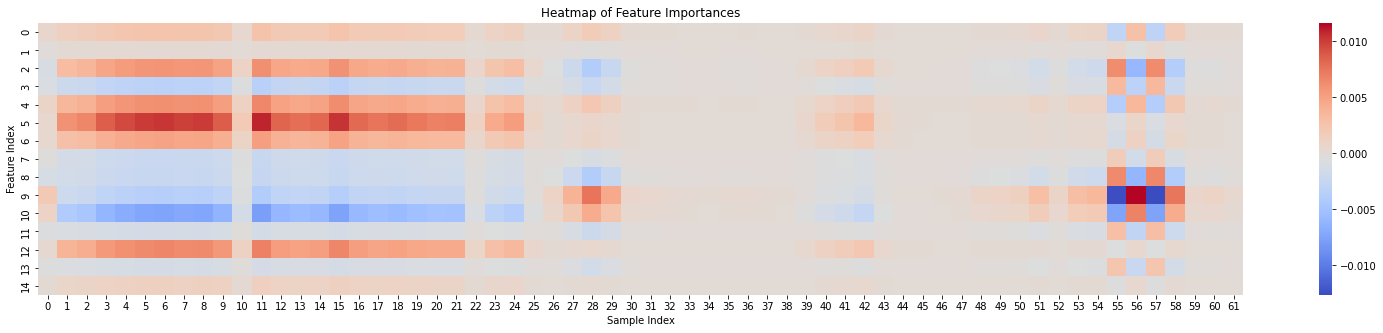

In [315]:
plt.figure(figsize=(27, 5))
sns.heatmap(fea_imp_all[0][:,:15].T, cmap='coolwarm', annot=False)
plt.title('Heatmap of Feature Importances')
plt.ylabel('Feature Index')
plt.xlabel('Sample Index')
plt.show()
